In [1]:
#Q3:
# ============================================
# Scaled Dot-Product Attention (FULL CODE)
# ============================================

import numpy as np
import torch
import math

# --------------------------------------------
# NumPy version
# --------------------------------------------
def scaled_dot_product_attention_numpy(Q, K, V):
    """
    Q: (n_q, d_k)
    K: (n_k, d_k)
    V: (n_k, d_v)

    Returns:
    output: (n_q, d_v)
    attention_weights: (n_q, n_k)
    """
    d_k = Q.shape[-1]

    # QK^T / sqrt(d_k)
    scores = Q @ K.T / np.sqrt(d_k)

    # Numerically stable softmax (row-wise)
    scores = scores - np.max(scores, axis=1, keepdims=True)
    attention_weights = np.exp(scores)
    attention_weights /= np.sum(attention_weights, axis=1, keepdims=True)

    # Weighted sum
    output = attention_weights @ V

    return output, attention_weights


# --------------------------------------------
# PyTorch version
# --------------------------------------------
def scaled_dot_product_attention_torch(Q, K, V):
    """
    Q: (n_q, d_k)
    K: (n_k, d_k)
    V: (n_k, d_v)

    Returns:
    output: (n_q, d_v)
    attention_weights: (n_q, n_k)
    """
    d_k = Q.size(-1)

    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    attention_weights = torch.softmax(scores, dim=-1)
    output = torch.matmul(attention_weights, V)

    return output, attention_weights


# --------------------------------------------
# Test / Example
# --------------------------------------------
if __name__ == "__main__":
    np.random.seed(0)
    torch.manual_seed(0)

    n_q, n_k, d_k, d_v = 3, 4, 5, 6

    # NumPy inputs
    Q_np = np.random.randn(n_q, d_k)
    K_np = np.random.randn(n_k, d_k)
    V_np = np.random.randn(n_k, d_v)

    out_np, attn_np = scaled_dot_product_attention_numpy(Q_np, K_np, V_np)

    print("NumPy output shape:", out_np.shape)
    print("NumPy attention shape:", attn_np.shape)
    print("NumPy attention row sums :", attn_np.sum(axis=1))
    print()

    # PyTorch inputs
    Q_t = torch.tensor(Q_np, dtype=torch.float32)
    K_t = torch.tensor(K_np, dtype=torch.float32)
    V_t = torch.tensor(V_np, dtype=torch.float32)

    out_t, attn_t = scaled_dot_product_attention_torch(Q_t, K_t, V_t)

    print("PyTorch output shape:", out_t.shape)
    print("PyTorch attention shape:", attn_t.shape)
    print("PyTorch attention row sums :", attn_t.sum(dim=1))


NumPy output shape: (3, 6)
NumPy attention shape: (3, 4)
NumPy attention row sums (should be 1): [1. 1. 1.]

PyTorch output shape: torch.Size([3, 6])
PyTorch attention shape: torch.Size([3, 4])
PyTorch attention row sums (should be 1): tensor([1.0000, 1.0000, 1.0000])


In [2]:
#Q4:
# ============================================================
# Scaled Dot-Product Attention with Causal (Future) Mask
# ============================================================

import numpy as np
import torch
import math

# ------------------------------------------------------------
# NumPy version (with causal mask)
# ------------------------------------------------------------
def masked_scaled_dot_product_attention_numpy(Q, K, V):
    """
    Q: (T, d_k)
    K: (T, d_k)
    V: (T, d_v)

    Returns:
    output: (T, d_v)
    attention_weights: (T, T)
    """
    T, d_k = Q.shape

    # Step 1: raw attention scores
    scores = Q @ K.T / np.sqrt(d_k)

    # Step 2: causal mask (upper triangular = future tokens)
    mask = np.triu(np.ones((T, T)), k=1)
    scores[mask == 1] = -np.inf

    # Step 3: softmax (row-wise, stable)
    scores = scores - np.max(scores, axis=1, keepdims=True)
    attention_weights = np.exp(scores)
    attention_weights /= np.sum(attention_weights, axis=1, keepdims=True)

    # Step 4: weighted sum
    output = attention_weights @ V

    return output, attention_weights


# ------------------------------------------------------------
# PyTorch version (with causal mask)
# ------------------------------------------------------------
def masked_scaled_dot_product_attention_torch(Q, K, V):
    """
    Q: (T, d_k)
    K: (T, d_k)
    V: (T, d_v)

    Returns:
    output: (T, d_v)
    attention_weights: (T, T)
    """
    T, d_k = Q.size()

    scores = torch.matmul(Q, K.T) / math.sqrt(d_k)

    # causal mask
    mask = torch.triu(torch.ones(T, T), diagonal=1).bool()
    scores = scores.masked_fill(mask, float('-inf'))

    attention_weights = torch.softmax(scores, dim=-1)
    output = torch.matmul(attention_weights, V)

    return output, attention_weights


# ------------------------------------------------------------
# Demonstration: masking blocks future tokens
# ------------------------------------------------------------
if __name__ == "__main__":
    np.random.seed(0)
    torch.manual_seed(0)

    T, d_k, d_v = 5, 4, 3

    Q_np = np.random.randn(T, d_k)
    K_np = np.random.randn(T, d_k)
    V_np = np.random.randn(T, d_v)

    out_np, attn_np = masked_scaled_dot_product_attention_numpy(Q_np, K_np, V_np)

    print("NumPy Attention Weights:")
    print(np.round(attn_np, 3))
    print("\nUpper triangle (future positions):")
    print(np.triu(attn_np, k=1))
    print()

    Q_t = torch.tensor(Q_np, dtype=torch.float32)
    K_t = torch.tensor(K_np, dtype=torch.float32)
    V_t = torch.tensor(V_np, dtype=torch.float32)

    out_t, attn_t = masked_scaled_dot_product_attention_torch(Q_t, K_t, V_t)

    print("PyTorch Attention Weights:")
    print(torch.round(attn_t, decimals=3))
    print("\nUpper triangle (future positions):")
    print(torch.triu(attn_t, diagonal=1))


NumPy Attention Weights:
[[1.    0.    0.    0.    0.   ]
 [0.006 0.994 0.    0.    0.   ]
 [0.265 0.189 0.545 0.    0.   ]
 [0.079 0.4   0.407 0.113 0.   ]
 [0.018 0.556 0.19  0.045 0.191]]

Upper triangle (future positions):
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

PyTorch Attention Weights:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0060, 0.9940, 0.0000, 0.0000, 0.0000],
        [0.2650, 0.1890, 0.5450, 0.0000, 0.0000],
        [0.0790, 0.4000, 0.4070, 0.1130, 0.0000],
        [0.0180, 0.5560, 0.1900, 0.0450, 0.1910]])

Upper triangle (future positions):
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

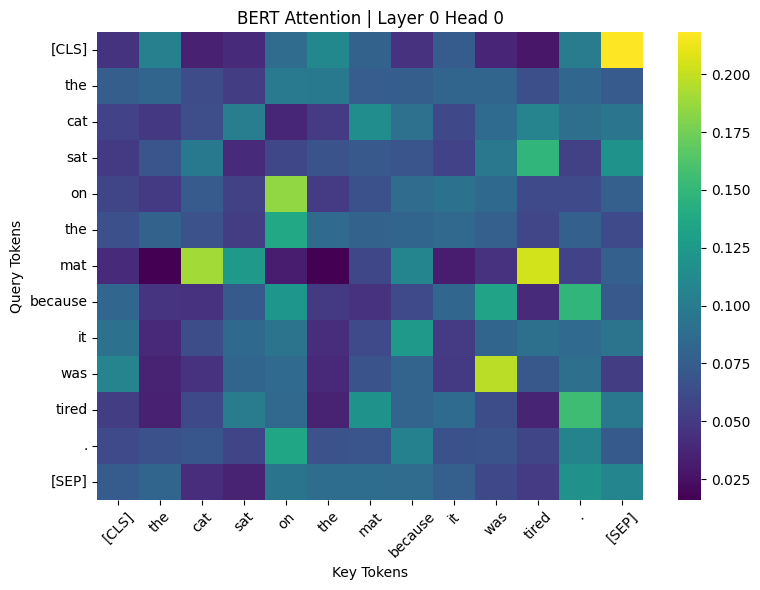

In [1]:
#Q5:
# ============================================================
# Visualize Attention Heads from a Pretrained Transformer (BERT)
# ============================================================

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel

# ------------------------------------------------------------
# Load pretrained BERT with attentions enabled
# ------------------------------------------------------------
model_name = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(
    model_name,
    output_attentions=True
)

model.eval()

# ------------------------------------------------------------
# Input sentence
# ------------------------------------------------------------
sentence = "The cat sat on the mat because it was tired."

inputs = tokenizer(sentence, return_tensors="pt")

# ------------------------------------------------------------
# Forward pass
# ------------------------------------------------------------
with torch.no_grad():
    outputs = model(**inputs)

# Attention format:
# tuple of length = num_layers
# each element: (batch_size, num_heads, seq_len, seq_len)
attentions = outputs.attentions

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# ------------------------------------------------------------
# Choose layer and head to visualize
# ------------------------------------------------------------
layer_idx = 0    # 0 = first layer
head_idx = 0     # attention head index

attention_matrix = attentions[layer_idx][0, head_idx]

# ------------------------------------------------------------
# Plot attention map
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(
    attention_matrix,
    xticklabels=tokens,
    yticklabels=tokens,
    cmap="viridis"
)

plt.title(f"BERT Attention | Layer {layer_idx} Head {head_idx}")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [17]:
import tensorflow as tf
from tensorflow.keras import layers,Model

In [15]:
# -----------------------------
# Positional Encoding Layer
# -----------------------------
class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(max_len, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.pow(
    10000.,
    tf.cast(2 * (i // 2), tf.float32) / tf.cast(d_model, tf.float32)
)

        return tf.cast(pos, tf.float32) * angle_rates


    def positional_encoding(self, max_len, d_model):
      angle_rads = self.get_angles(
          pos=tf.range(max_len)[:, tf.newaxis],
          i=tf.range(d_model)[tf.newaxis, :],
          d_model=d_model
      )

      # QUESTION : apply sin to even indices, cos to odd
      sines = tf.sin(angle_rads[:, 0::2])
      cosines = tf.cos(angle_rads[:, 1::2])
      angle_rads = tf.concat([sines, cosines], axis=-1)

      return angle_rads[tf.newaxis, ...]


    def call(self, x):
        return x + tf.cast(self.pos_encoding[:, :tf.shape(x)[1], :], x.dtype)


In [19]:
# -----------------------------
# Transformer Encoder Block
# -----------------------------
def transformer_encoder_block(embed_dim, num_heads, ff_dim, dropout=0.1):
    inputs = layers.Input(shape=(None, embed_dim))

    # QUESTION : Apply Layer Norm + MultiHead Attention
    x = layers.LayerNormalization()(inputs)  # normalization
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads,
        dropout=dropout
    )(x, x)
    x = layers.Add()([inputs, attention_output])  # Residual

    # QUESTION : Apply Feed Forward Network with Approrpriate Activation fxn
    ff = layers.LayerNormalization()(x)
    ff = layers.Dense(ff_dim, activation="relu")(ff)
    ff = layers.Dense(embed_dim)(ff)
    x = layers.Add()([x, ff])  # Residual

    return Model(inputs, x)



In [8]:

# -----------------------------
# Build the Transformer Model
# -----------------------------
def build_transformer(
        max_len=100,
        vocab_size=10000,
        embed_dim=64,
        num_heads=4,
        ff_dim=128,
        num_layers=3
    ):
    inputs = layers.Input(shape=(None,), dtype=tf.int32)

    # QUESTION : Apply Token Embedding and Positional Encoding

    x = layers.Embedding(vocab_size, embed_dim)(inputs)  # embedding
    x = PositionalEncoding(max_len, embed_dim)(x)        # positional encoding

    # 3 Transformer Encoder Blocks
    for _ in range(num_layers):
        x = transformer_encoder_block(embed_dim, num_heads, ff_dim)(x)

    # Classification head (example)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs, name="Transformer_3Layer")
    return model


In [20]:
# -----------------------------
# Instantiate + Compile Model
# -----------------------------
model = build_transformer()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # fill appropriate learning rate
    loss="binary_crossentropy",                               # fill appropriate loss fxn
    metrics=["accuracy"]
)

model.summary()


Model: "Transformer_3Layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_6           │ (None, None, 64)       │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, None, 64)       │        33,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, None, 64)       │        33,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ (None, None, 64)       │        33,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 744,641 (2.84 MB)

 Trainable params: 744,641 (2.84 MB)

 Non-trainable params: 0 (0.00 B)